Step 1 – Importing required libraries for Emotion Detector.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from keras.models import load_model
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
import seaborn as sns

Step 2 – Reading all images and storing them in a dataframe.

In [2]:
int_emo = {0:"angry",1:"fear",2:"happy",3:"neutral",4:"sad", 5:"surprise"}
emo_int = {"angry":0, "fear":1, "happy":2, "neutral":3, "sad":4, "surprise":5}

In [3]:
dic = {'image':[], "labels":[], "purpose":[]}

-Here we are simply reading our data and storing it in a pandas dataframe.
-Images contain images with the shape 48X48X1.
-Labels depict the emotion of that image.
-Purpose has 2 values T and V. T is for training and V for validation.

In [4]:
for d in os.listdir('images/'):
    print(d)
    for emo in os.listdir(f'images/{d}'):
        print(emo)
        for i in os.listdir(f'images\{d}/{emo}'):
            img = cv2.imread(f'images/{d}/{emo}/{i}',0)
            img = img.reshape(48,48,1)
            dic['image'].append(img)
            dic['labels'].append(emo)
            if d=='train':
                dic['purpose'].append("T")
            else:
                dic['purpose'].append("V") #v = validation = test

test
angry
fear
happy
neutral
sad
surprise
train
angry
fear
happy
neutral
sad
surprise


In [5]:
df = pd.DataFrame(dic)
df.sample(5)

,image,labels,purpose
25266,"[[[52], [56], [41], [40], [54], [93], [110], [...",neutral,T
5458,"[[[4], [2], [1], [1], [2], [2], [2], [2], [5],...",sad,V
14684,"[[[109], [109], [110], [101], [78], [46], [35]...",fear,T
12702,"[[[1], [0], [1], [0], [0], [1], [1], [0], [1],...",fear,T
21226,"[[[88], [90], [76], [67], [78], [78], [80], [8...",happy,T


Step 3 – Extracting training data and validation data.

Creating 2 different data frames.
First for the training and second for test.

In [6]:
train_data = df[df['purpose']=='T']
test_data = df[df['purpose']=='V']

Check the head of training data.


In [7]:
train_data.head()

,image,labels,purpose
6955,"[[[72], [78], [81], [75], [59], [54], [63], [6...",angry,T
6956,"[[[152], [149], [147], [157], [146], [133], [1...",angry,T
6957,"[[[29], [25], [21], [23], [26], [24], [49], [6...",angry,T
6958,"[[[32], [23], [20], [56], [43], [34], [38], [4...",angry,T
6959,"[[[222], [218], [202], [189], [199], [208], [1...",angry,T


In [8]:
train_data.shape

(28385, 3)

Check the head of testing data.


In [9]:
test_data.head()

,image,labels,purpose
0,"[[[58], [66], [70], [77], [117], [154], [137],...",angry,V
1,"[[[23], [26], [21], [9], [6], [19], [33], [11]...",angry,V
2,"[[[201], [182], [182], [184], [205], [204], [2...",angry,V
3,"[[[93], [86], [78], [78], [80], [92], [109], [...",angry,V
4,"[[[11], [6], [1], [0], [0], [1], [0], [0], [2]...",angry,V


Step 4 – Check values in the labels column of train data.

As we can see in the image below that the labels are very unbalanced in the training data so we will balance them in the next step.

In [10]:
train_data['labels'].value_counts()

labels
happy       7164
neutral     4982
sad         4938
fear        4103
angry       3993
surprise    3205
Name: count, dtype: int64

In [11]:
train_data.shape

(28385, 3)

Step 5 – Taking equal instances of all classes.

In [12]:
happy_df = train_data[train_data['labels']=='happy'].sample(n=3205)
neutral_df = train_data[train_data['labels']=='neutral'].sample(n=3205)
sad_df = train_data[train_data['labels']=='sad'].sample(n=3205)
fear_df = train_data[train_data['labels']=='fear'].sample(n=3205)
angry_df = train_data[train_data['labels']=='angry'].sample(n=3205)
surprise_df = train_data[train_data['labels']=='surprise'].sample(n=3205)

train_data = pd.concat([happy_df,neutral_df,sad_df,fear_df,angry_df,surprise_df])

train_data = train_data.sample(frac=1)
train_data.reset_index(inplace=True)
train_data.drop('index',inplace=True,axis=1)

train_data.head()

,image,labels,purpose
0,"[[[228], [209], [212], [218], [204], [173], [8...",fear,T
1,"[[[27], [38], [25], [17], [45], [35], [27], [2...",happy,T
2,"[[[47], [32], [6], [1], [0], [2], [5], [8], [1...",angry,T
3,"[[[213], [208], [191], [194], [210], [224], [2...",sad,T
4,"[[[254], [254], [255], [255], [253], [255], [2...",fear,T


In [13]:
label_counts = train_data['labels'].value_counts()
print("Available samples for each label:")
print(label_counts)

Available samples for each label:
labels
fear        3205
happy       3205
angry       3205
sad         3205
surprise    3205
neutral     3205
Name: count, dtype: int64


Plotting the column.

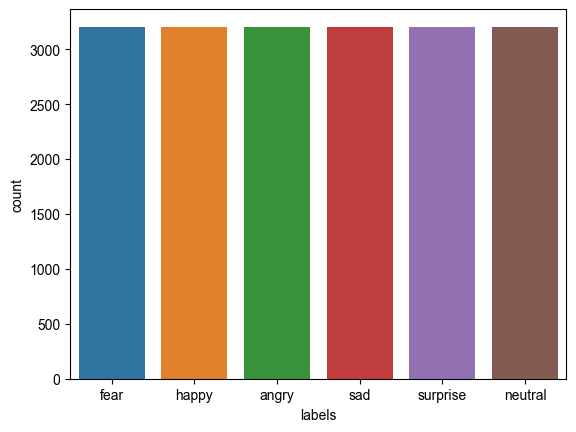

In [14]:
sns.countplot(train_data, x='labels', hue='labels')
sns.set_theme(rc={'figure.figsize':(7,2)})

Step 7 – Declaring some constants.

In [15]:
batch_size = 32
classes = 6
rows,columns = 48,48

Step 8 – Getting data for the Emotion Detector model in the right shape.

In [16]:
#Convert emotions to ints like Angry to 0, Fear to 1, and so on, and then convert these numbers to one-hot encoded using to_categorical. This is for train data.
train_labels = list(train_data['labels'].replace(emo_int))
train_labels = to_categorical(train_labels)

#Doing the same as above for test data.
test_labels = list(test_data['labels'].replace(emo_int))
test_labels = to_categorical(test_labels)

# Converting image column to list and then to a NumPy array for training purposes because we will not be using dataframe columns for training purposes, hence we will convert them to arrays.
train_data = list(train_data['image'])
train_data = np.array(train_data)

# Doing the same as above for test data.
test_data = list(test_data['image'])
test_data = np.array(test_data)

C:\Users\aditi\AppData\Local\Temp\ipykernel_10680\530630387.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_labels = list(train_data['labels'].replace(emo_int))
C:\Users\aditi\AppData\Local\Temp\ipykernel_10680\530630387.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_labels = list(test_data['labels'].replace(emo_int))


In [17]:
train_data.shape

(19230, 48, 48, 1)

In [18]:
test_data.shape

(6955, 48, 48, 1)

Step 9 – Creating the Emotion Detector model.

Creating our Convolutional Neural Network model.
Creating 4 blocks of Conv2D – BatchNormalization – Conv2D – BatchNormalization – MaxPooling2D – Dropout layers.
Creating 3 blocks of Dense – Batch – Dropout layers and finally creating 1 Dense layer having 6 neurons/nodes.

In [19]:
model = Sequential()

#first block
model.add(Conv2D(64,(3,3), activation='elu', input_shape=(rows, columns,1), kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation='elu', input_shape=(rows, columns,1), kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#second block
model.add(Conv2D(128,(3,3), activation='elu', input_shape=(rows, columns,1), kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), activation='elu', input_shape=(rows, columns,1), kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#third block
model.add(Conv2D(256,(3,3), activation='elu', input_shape=(rows, columns,1), kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), activation='elu', input_shape=(rows, columns,1), kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#fourth block
model.add(Conv2D(512,(3,3), activation='elu', input_shape=(rows, columns,1), kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3), activation='elu', input_shape=(rows, columns,1), kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#fifth block
model.add(Flatten())
model.add(Dense(256, activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#sixth block
model.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#seventh block
model.add(Dense(64, activation='elu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#eighth block
model.add(Dense(classes, activation='softmax', kernel_initializer='he_normal'))

print(model.summary())


C:\Users\aditi\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,915,142 (22.56 MB)

 Trainable params: 5,910,406 (22.55 MB)

 Non-trainable params: 4,736 (18.50 KB)

None


Step 10 – Declaring callbacks.

In [20]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('emo_v2.keras',
                            save_best_only = True,
                            mode = 'min',
                            monitor = 'val_loss',
                            verbose=1)
earlyStopping = EarlyStopping(patience=10,
                              verbose = 1,
                              min_delta = 0,
                              monitor = 'val_loss',
                              restore_best_weights = True)
callbacks = [checkpoint, earlyStopping]
model.compile(metrics=['accuracy'],
              optimizer = 'rmsprop',
              loss = 'categorical_crossentropy')

Step 11 – Training the model.

finally training the model

In [21]:
train_samples = 28273
test_samples = 6955
batch_size = 64
epochs = 20

history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    steps_per_epoch = train_samples//batch_size,
                    validation_data =(test_data,test_labels),
                    validation_steps = test_samples//batch_size,
                    callbacks = callbacks)

Epoch 1/20
438/441 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step - accuracy: 0.1865 - loss: 2.4268

c:\Program Files\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 1.79662, saving model to emo_v2.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 297s 665ms/step - accuracy: 0.1865 - loss: 2.4253 - val_accuracy: 0.2013 - val_loss: 1.7966
Epoch 2/20
438/441 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step - accuracy: 0.2203 - loss: 1.8267
Epoch 2: val_loss improved from 1.79662 to 1.65929, saving model to emo_v2.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 290s 658ms/step - accuracy: 0.2205 - loss: 1.8262 - val_accuracy: 0.3282 - val_loss: 1.6593
Epoch 3/20
438/441 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - accuracy: 0.3493 - loss: 1.5681
Epoch 3: val_loss improved from 1.65929 to 1.46945, saving model to emo_v2.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 292s 663ms/step - accuracy: 0.3495 - loss: 1.5677 - val_accuracy: 0.3997 - val_loss: 1.4695
Epoch 4/20
438/441 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step - accuracy: 0.4566 - loss: 1.3745
Epoch 4: val_loss improved from 1.46945 to 1.29062, saving model to emo_v2.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 289s 656ms/step - accur

Step 12 – Live Prediction.

In [22]:
import cv2
from keras.models import load_model
import numpy as np

In [23]:
int_emo = {0:"angry",1:"fear",2:"happy",3:"neutral",4:"sad", 5:"surprise"}
model = load_model('emo_v2.keras')

classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def detect_face(frame):
    faces=classifier.detectMultiScale(frame,1.3,4)
    if len(faces)==0:
        return frame
    for x,y,w,h in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(172,42,251),2)
        face = frame[y:y+h,x:x+w]
        face = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face,(48,48))
        face = face.reshape(1,48,48,1)
        cv2.putText(frame,text=int_emo[np.argmax(model.predict(face))],
                    org=(x,y-15),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(106,40,243),thickness=2)
    return frame


In [ ]:
cap = cv2.VideoCapture(0)
while 1:
    ret,frame= cap.read()
    if ret==True:
        cv2.imshow('emotion_detector',detect_face(frame))
        if cv2.waitKey(1)==27:
            break
cap.release()
cv2.destroyAllWindows()